In [ ]:
"General/ Basic Assumptions Model"

# 1. Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 2. Input Data - PVT, Well Test, Constraints

# Reservoir and Surface Conditions
P_res_short = 1196      # psia
P_res_long = 1362       # psia
T_res_short = 128       # °F
T_res_long = 134        # °F
PI_short = 2.3          # STB/d/psi
PI_long = 2.05          # STB/d/psi
P_surface = 100         # psia

# Gas Injection
G_injection_surface = 1.7E06    # scf/d (approx. 1.7 MMSCFD)

In [3]:
# 3. Sensitivity Parameters

GIR_values = np.linspace(0.5E06, 3.0E06, 6)     # Gas Injection rate (scf/d)
PI_values = np.linspace(0.8, 1.5, 5)            # Productivity Index (STB/d/psi)
DomeP_values = np.linspace(1800, 2400, 4)       # Dome Pressure (psia)
DeltaP_valve_values = np.linspace(50, 300, 6)   # Pressure Drop (psia)

In [ ]:
# 4. Calcualating Energy Efficiency

def calc_energy_eff(GIR, Qliq_short, Qliq_long, DomeP, P_surface):
    """
    Calculate energy efficiency based on gas compression work vs liquid lifting work
    """
    
    # Constants
    n = 1.03                # Polytropic exponent (assuming some heat exchange)
    R = 10.73               # Gas constant (psis/ ft³)/(lbmol.°R)
    T_surface = 520         # Rankine (approx 60°F)
    g = 32.174              # ft/s²
    rho_liquid = 50         # lb/ft³ (rough oil)
    H = 4000                # lift height in ft
    bbl_to_ft3 = 5.615      # conversion
    
    # Volume of gas injected (ft³/day) = scf/day
    V1 = GIR                # scf/day
    
    # Compression Work (per day)
    comp_work = (n / (n - 1)) * P_surface * V1 * (((DomeP / P_surface) ** ((n - 1)) - 1))   # (ft-lbf/day)
    
    # Liquid lifting work (short + long string)
    Qliq_total = Qliq_short + Qliq_long     # (STB/day)
    fluid_work = Qliq_total + bbl_to_ft3 * rho_liquid * g * H   # (ft-lbf/day)
    
    # Energy Efficiency
    eff = fluid_work / comp_work if comp_work != 0 else 0
    
    return eff    

In [5]:
# 5. Calculating CO₂ Emissions

def est_CO2_emiss(fuel_used_scf_per_day, heating_value_btu_per_scf=1030, emiss_factor_kg_per_mmbtu=53.06):
    energy_btu = fuel_used_scf_per_day *heating_value_btu_per_scf
    energy_mmbtu = energy_btu / 1E06
    CO2_kg_per_day = energy_mmbtu * emiss_factor_kg_per_mmbtu
    return CO2_kg_per_day / 1000        # convert to metric tons/day

In [6]:
# 6. Sensitivity Analysis Loop

results = []

for GIR in GIR_values:
    for PI in PI_values:
        for DomeP in DomeP_values:
            for DeltaP in DeltaP_valve_values:
                Q_liq_short = PI * (P_res_short - P_surface)
                Q_liq_long = PI * (P_res_long - P_surface)
                GLR_short = GIR / Q_liq_short
                GLR_long = GIR / Q_liq_long
                
                # Energy efficiency
                energy_eff = calc_energy_eff(GIR, Q_liq_short, Q_liq_long, DomeP, P_surface)
                
                # CO₂ emissions
                fuel_used = GIR * 0.10      # assume 10% of injected gas used as fuel (depend on compressor fuel usage)
                CO2_emission = est_CO2_emiss(fuel_used)
                
                # Economic estimation
                oil_price = 65          # USD/bbl
                gas_price = 3.7         # USD/Mscf
                revenue = (Q_liq_short + Q_liq_long) * oil_price
                gas_cost = (GIR / 1000) * gas_price
                profit = revenue - gas_cost
                
                results.append({
                    'GIR': GIR,
                    'PI': PI,
                    'DomeP': DomeP,
                    'DeltaP': DeltaP,
                    'Q_liq_short': Q_liq_short,
                    'Q_liq_long': Q_liq_long,
                    'Energy Efficiency': energy_eff,
                    'CO2_emission': CO2_emission,
                    'Revenue': revenue,
                    'Gas_Cost': gas_cost,
                    'Profit': profit
                })

In [7]:
# 7. Convert to DF and Save toCSV

df_results = pd.DataFrame(results)
df_results.to_csv('Gas_Lift_Sensitivity_Results.csv', index=False)
df_results.head()

,GIR,PI,DomeP,DeltaP,Q_liq_short,Q_liq_long,Energy Efficiency,CO2_emission,Revenue,Gas_Cost,Profit
0,500000.0,0.8,1800.0,50.0,876.8,1009.6,0.232371,2.73259,122616.0,1850.0,120766.0
1,500000.0,0.8,1800.0,100.0,876.8,1009.6,0.232371,2.73259,122616.0,1850.0,120766.0
2,500000.0,0.8,1800.0,150.0,876.8,1009.6,0.232371,2.73259,122616.0,1850.0,120766.0
3,500000.0,0.8,1800.0,200.0,876.8,1009.6,0.232371,2.73259,122616.0,1850.0,120766.0
4,500000.0,0.8,1800.0,250.0,876.8,1009.6,0.232371,2.73259,122616.0,1850.0,120766.0


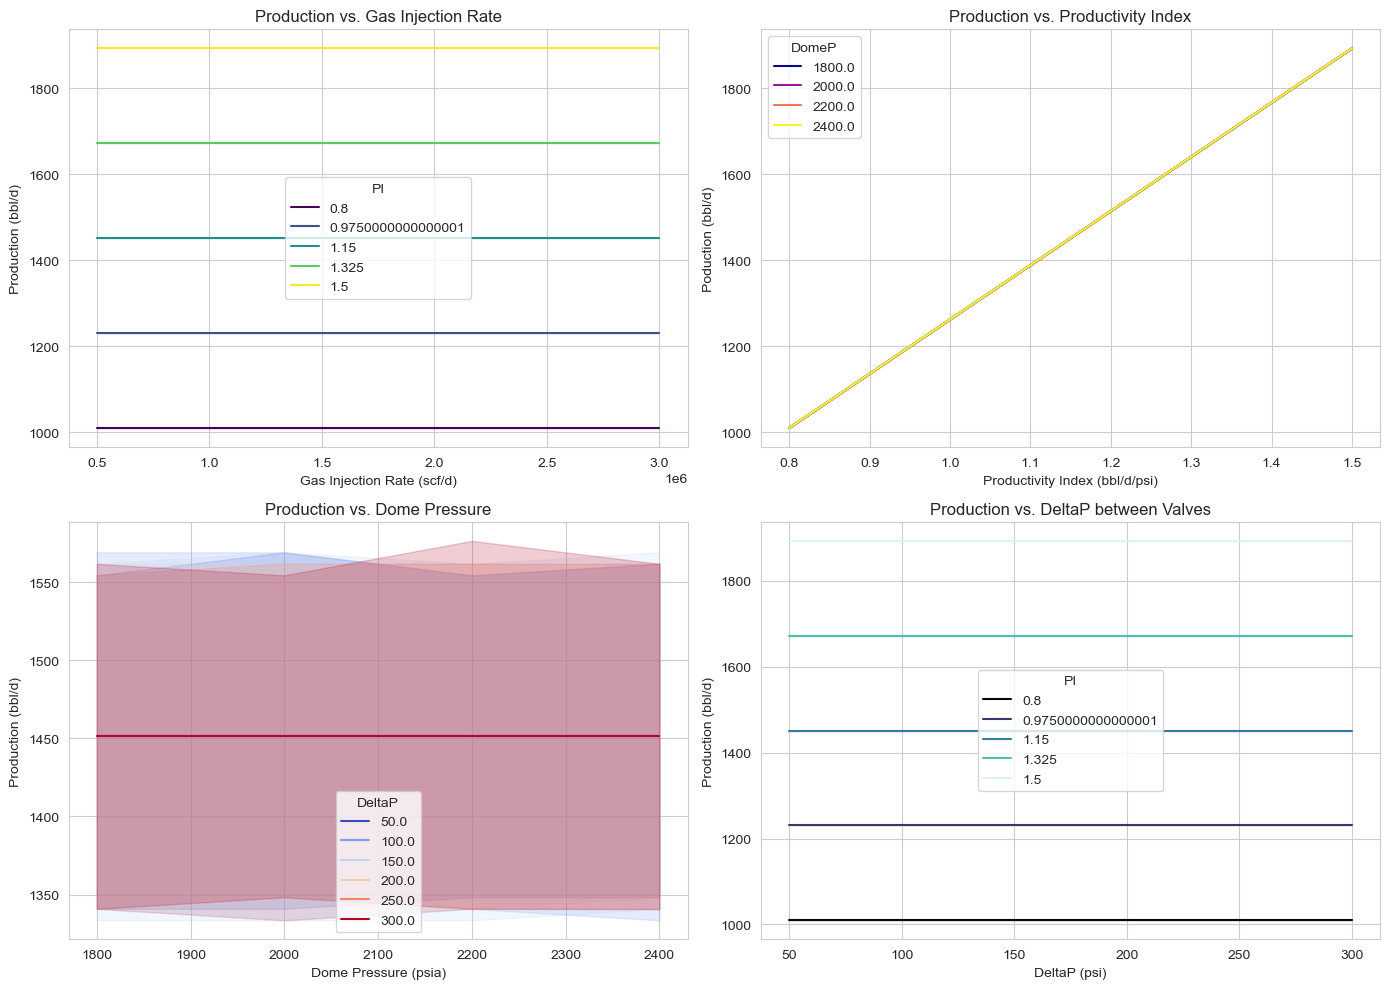

In [8]:
# 8. Example Plot

sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: GIR vs. Production
sns.lineplot(x='GIR', y='Q_liq_long', hue='PI', data=df_results, palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Production vs. Gas Injection Rate')
axes[0, 0].set_xlabel('Gas Injection Rate (scf/d)')
axes[0, 0].set_ylabel('Production (bbl/d)')

# Plot 2: PI vs Production
sns.lineplot(x='PI', y='Q_liq_long', hue='DomeP', data=df_results, palette='plasma', ax=axes[0, 1])
axes[0, 1].set_title('Production vs. Productivity Index')
axes[0, 1].set_xlabel('Productivity Index (bbl/d/psi)')
axes[0, 1].set_ylabel('Poduction (bbl/d)')

# Plot 3: Dome Pressure vs Production
sns.lineplot(x='DomeP', y='Q_liq_long', hue='DeltaP', data=df_results, palette='coolwarm', ax=axes[1, 0])
axes[1, 0].set_title('Production vs. Dome Pressure')
axes[1, 0].set_xlabel('Dome Pressure (psia)')
axes[1, 0].set_ylabel('Production (bbl/d)')

# Plot 4: DeltaP vs Production
sns.lineplot(x='DeltaP', y='Q_liq_long', hue='PI', data=df_results, palette='mako', ax=axes[1, 1])
axes[1, 1].set_title('Production vs. DeltaP between Valves')
axes[1, 1].set_xlabel('DeltaP (psi)')
axes[1, 1].set_ylabel('Production (bbl/d)')

plt.tight_layout()
plt.show()


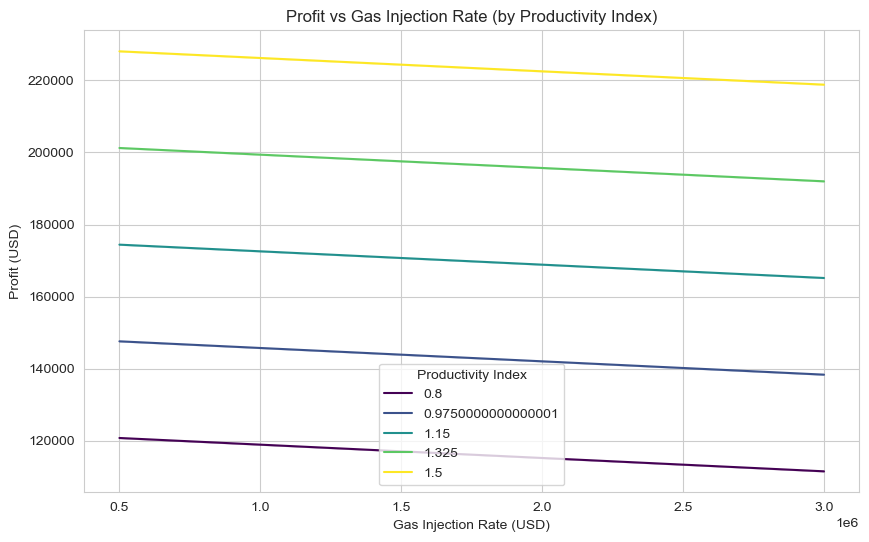

In [9]:
# 9. (Optional) Example Plot

sns.set_style('whitegrid')

plt.figure(figsize=(10, 6))
sns.lineplot(x='GIR', y='Profit', data=df_results, hue='PI', palette='viridis')
plt.title('Profit vs Gas Injection Rate (by Productivity Index)')
plt.xlabel('Gas Injection Rate (USD)')
plt.ylabel('Profit (USD)')
plt.legend(title='Productivity Index')
plt.show()